In [3]:
import PyPlot
using NearestNeighbors
using SplineUtils
using RoadwayNetworks
using GeomUtils
using LightGraphs

# Some LightGraphs stuff

# Construct Intersection from list of incoming lanes and transitions

In [2]:
function populateIntersection!(intersection,urbanMap;LanesIn=nothing,width=1,buffer=1,Δs=0.5)
    """
    Populates the geometry and metadata of an intersection from a list of incoming lanes and transitions
    """
    w = width
    b = buffer
    
    x₀ = intersection.x
    y₀ = intersection.y
    
    if LanesIn == nothing
        LanesIn = intersection.LanesIn
    else
        intersection.LanesIn = LanesIn
    end
    
    Directions = [:North, :East, :South, :West]
#     for k in Directions
#         road = Road(getId!(urbanMap))
#     end
    
    θ = intersection.θ
    # account for shearing when Δθ is not exactly 90 degrees
    τ = abs(1.0 / dot([cos(θ[:East]);sin(θ[:East])],[cos(θ[:North]-π/2);sin(θ[:North]-π/2)]))
    w = w * τ
    LanesOut = Dict( k => [Set([:Straight]) for i in 1:max(
                    sum([Int(:Straight in lane) for lane in LanesIn[k]]),
                    sum([Int(:Left in lane) for lane in LanesIn[Right[k]]]),
                    sum([Int(:Right in lane) for lane in LanesIn[Left[k]]]),)] for k in Directions)
    D = Dict( k => max(length(LanesIn[k]) + length(LanesOut[Opposite[k]]),
            length(LanesIn[Opposite[k]]) + length(LanesOut[k])) for k in Directions)
    # incoming lanes - lateral position begins from the right side                          
    PositionsIn = Dict( k => [i for i in 1:length(LanesIn[k])] for k in Directions)
    # reference positions - for specifying incoming roadway geometry
    PositionRefs = Dict( 
        k => sum([Int(:Straight in lane || :Right in lane) for lane in LanesIn[k]]) for k in Directions)
    # outgoing lanes - lateral position counts down from left side (leftover positions are empty--no lanes in them)
    PositionsOut = Dict( k => [D[k] + 1 - i for i in 1:length(LanesOut[k])] for k in Directions)
    d = Dict( k => w*D[k]/2 + b for k in Directions)
    d_vecs = Dict( k => d[Right[k]] * Rot(θ[k]) * [1;0] for k in Directions)
    ctrs = Dict( k => d_vecs[k] + [x₀;y₀] for k in Directions)
    corners = Dict((k, Left[k]) => d_vecs[k] + d_vecs[Left[k]] + [x₀;y₀] for k in Directions)
    # entry points
    CurveStartPoints = Dict( k => [(corners[Opposite[k], Right[k]] .+ normalize(
                    d_vecs[Left[k]])*(w*(p-.5) + b)) for p in PositionsIn[k]] for k in Directions)
    # exit points
    CurveEndPoints = Dict(k => [(corners[(k, Left[k])] .+ normalize(
                    d_vecs[Right[k]])*(w*(p.-.5) + b)) for p in PositionsOut[k]] for k in Directions)
    
    # perpendicular entrance and exit points for appropriate connection geometry
    EntrancePoints = Dict()
    ExitPoints = Dict()
    RefPts_In = Dict()
    RefPts_Out = Dict()
    for k in Directions
        v₁ = [cos(θ[k]);sin(θ[k])]
        v₂ = [cos(θ[Right[k]]);sin(θ[Right[k]])]
        if dot(v₁, v₂) > 0
            θₚ = θ[k] - π/2
            vₚ = [cos(θₚ);sin(θₚ)]
            v₀ = corners[(Left[k], Opposite[k])]
            EntrancePoints[k] = [ v₀ + vₚ*dot(vₚ, v-v₀) for v in CurveStartPoints[k]]
            ExitPoints[Opposite[k]] = [ v₀+vₚ *  dot(vₚ, v-v₀) for v in CurveEndPoints[Opposite[k]]]
            RefPts_In[k] = EntrancePoints[k][PositionRefs[k]] .- vₚ*w/(2τ)
            RefPts_Out[Opposite[k]] = ExitPoints[Opposite[k]][end] .+ vₚ*w/(2τ)
        else
            θₚ = θ[k] + π/2
            vₚ = [cos(θₚ);sin(θₚ)]
            v₀ = corners[(Opposite[k], Right[k])]
            EntrancePoints[k] = [ v₀ + vₚ *  dot(vₚ, v-v₀) for v in CurveStartPoints[k]]
            ExitPoints[Opposite[k]] = [ v₀ + vₚ *  dot(vₚ, v-v₀) for v in CurveEndPoints[Opposite[k]]]
            RefPts_In[k] = EntrancePoints[k][PositionRefs[k]] .+ vₚ*w/(2τ)
            RefPts_Out[Opposite[k]] = ExitPoints[Opposite[k]][end] .- vₚ*w/(2τ)
        end
    end
#     # reference points in
#     RefPts_In = Dict(
#         k => EntrancePoints[k][PositionRefs[k]] .+ normalize(d_vecs[Left[k]])*w*0.5 for k in Directions)
#     # reference points out
#     RefPts_Out = Dict(k => ExitPoints[k][end] .+ normalize(d_vecs[Left[k]])*w*0.5 for k in Directions)
    
    # intersection ref points
    for (k, pt) in RefPts_In
        intersection.refpoints[k][:in] = pt
    end
    for (k, pt) in RefPts_Out
        intersection.refpoints[k][:out] = pt
    end

    for (j,direction) in enumerate(Directions)
        for (i,lane) in enumerate(reverse(LanesIn[direction]))
            if :Straight in lane
                exit_direction = direction
                pt₀ = EntrancePoints[direction][i]
                pt₁ = CurveStartPoints[direction][i]
                pt₂ = CurveEndPoints[direction][i]
                pt₃ = ExitPoints[direction][i]
#                 x = collect(linspace(pt₁[1],pt₂[1]))
#                 y = collect(linspace(pt₁[2],pt₂[2]))
                x = collect(linspace(pt₀[1],pt₃[1]))
                y = collect(linspace(pt₀[2],pt₃[2]))
                sₗ,θₗ,kₗ = ComputeFrenetCoordsFromCartesian(x,y;θ₁=θ[direction],θ₂=θ[direction])
                id = getId!(urbanMap.dispenser)
                urbanMap.lanes[id] = Lane(id,x,y,sₗ,θₗ,kₗ;width=w)
                
                offset1 = PositionRefs[direction] - i
                if !haskey(intersection.entrances[direction], offset1)
                    intersection.entrances[direction][offset1] = Set()
                end
                offset2 = PositionRefs[exit_direction] - i
                if !haskey(intersection.exits[exit_direction], offset2)
                    intersection.exits[exit_direction][offset2] = Set()
                end
                push!(intersection.entrances[direction][offset1], id)
                push!(intersection.exits[exit_direction][offset2], id)
                intersection.entrance_pts[direction][offset1] = pt₀
                intersection.exit_pts[exit_direction][offset2] = pt₃
            end
            if :Right in lane
                exit_direction = Right[direction]
                pt₀ = EntrancePoints[direction][i]
                pt₁ = CurveStartPoints[direction][i]
                pt₂ = CurveEndPoints[Right[direction]][i]
                pt₃ = ExitPoints[Right[direction]][i]
#                 x,y = Dubbins(pt₁,pt₂,θ[direction],θ[Right[direction]])
                x,y = ExtendedDubbins(pt₀,pt₁,pt₂,pt₃;θ₁=θ[direction],θ₂=θ[Right[direction]])
                sₗ,θₗ,kₗ = ComputeFrenetCoordsFromCartesian(x,y;θ₁=θ[direction],θ₂=θ[Right[direction]])
                id = getId!(urbanMap.dispenser)
                urbanMap.lanes[id] = Lane(id,x,y,sₗ,θₗ,kₗ;width=w)
                
                offset1 = PositionRefs[direction] - i
                if !haskey(intersection.entrances[direction], offset1)
                    intersection.entrances[direction][offset1] = Set()
                end
                offset2 = PositionRefs[exit_direction] - i
                if !haskey(intersection.exits[exit_direction], offset2)
                    intersection.exits[exit_direction][offset2] = Set()
                end
                push!(intersection.entrances[direction][offset1], id)
                push!(intersection.exits[exit_direction][offset2], id)
                intersection.entrance_pts[direction][offset1] = pt₀
                intersection.exit_pts[exit_direction][offset2] = pt₃
            end
        end
        for (i,lane) in enumerate(LanesIn[direction])
            if :Left in lane
                exit_direction = Left[direction]
                pt₀ = reverse(EntrancePoints[direction])[i]
                pt₁ = reverse(CurveStartPoints[direction])[i]
                pt₂ = reverse(CurveEndPoints[Left[direction]])[i]
                pt₃ = reverse(ExitPoints[Left[direction]])[i]
#                 x,y = Dubbins(pt₁,pt₂,θ[direction],θ[Left[direction]])
                x,y = ExtendedDubbins(pt₀,pt₁,pt₂,pt₃;θ₁=θ[direction],θ₂=θ[Left[direction]])
                sₗ,θₗ,kₗ = ComputeFrenetCoordsFromCartesian(x,y;θ₁=θ[direction],θ₂=θ[Left[direction]])
                id = getId!(urbanMap.dispenser)
                urbanMap.lanes[id] = Lane(id,x,y,sₗ,θₗ,kₗ;width=w)

                offset1 = PositionRefs[direction] - maximum(PositionsIn[direction]) + i - 1
                if !haskey(intersection.entrances[direction], offset1)
                    intersection.entrances[direction][offset1] = Set()
                end
                offset2 = i - 1
                if !haskey(intersection.exits[exit_direction], offset2)
                    intersection.exits[exit_direction][offset2] = Set()
                end
                
                push!(intersection.entrances[direction][offset1], id)
                push!(intersection.exits[exit_direction][offset2], id)
                intersection.entrance_pts[direction][offset1] = pt₀
                intersection.exit_pts[exit_direction][offset2] = pt₃
            end
        end
    end
#     return PositionsIn, PositionRefs, PositionsOut, d, d_vecs, ctrs, corners, CurveStartPoints, CurveEndPoints
    return EntrancePoints, ExitPoints
end

populateIntersection! (generic function with 1 method)

In [3]:
function GenerateRoadBetweenIntersections!(urbanMap, I1, I2, d_in, d_out; Δs₁=10, Δs₂=40, speed=50)
    
    entrances = I1.exits[d_in]
    exits = I2.entrances[d_out]
    
    idxs_in = Set(k for (k,v) in entrances)
    idxs_out = Set(k for (k,v) in exits)
    idxs_common = intersect(Set(idxs_out), Set(idxs_in))
    
    ref_pt_in = I1.refpoints[d_in][:out]
    exit_pts_in = I1.exit_pts[d_in]
    D_in = Dict()
    for idx in idxs_in
        D_in[idx] = dot(exit_pts_in[idx] - ref_pt_in, unitVec(I1.θ[d_in]-π/2))
    end

    ref_pt_out = I2.refpoints[d_out][:in]
    entrance_pts_out = I2.entrance_pts[d_out]
    D_out = Dict()
    for idx in idxs_out
        D_out[idx] = dot(entrance_pts_out[idx] - ref_pt_out, unitVec(I2.θ[d_out]-π/2))
    end
    
    spline = SplineFromEndPoints(ref_pt_in, ref_pt_out, I1.θ[d_in], I2.θ[d_out]);
    ref_line = Curve(spline.x, spline.y; s=spline.s, θ=spline.θ, k=spline.k)
    S = ref_line.s[end]
    ds = mean(diff(ref_line.s))
    
    if S - 2 * (Δs₁ + Δs₂) < 0
        # construct 3 roads
        # SEGMENT 1 - STRAIGHT SECTION    
        p₁ = 1
        p₂ = Int(round(Δs₁ / ds))
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_in, idxs_in, entrances, D_in, D_in, urbanMap)
        # SEGMENT 2 - FAN SECTION
        p₁ = p₂
        p₂ = Int(round((S-Δs₁) / ds))
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_in, idxs_out, connections, D_in, D_out, urbanMap)
        # SEGMENT 3 - STRAIGHT    
        p₁ = p₂
        p₂ = length(ref_line.s)
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_out, idxs_out, connections, D_out, D_out, urbanMap);
    else
        # construct 5 roads: straight, fan in, straight, fan out, straight
        # SEGMENT 1 - STRAIGHT SECTION
        p₁ = 1
        p₂ = Int(round(Δs₁ / ds))
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_in, idxs_in, entrances, D_in, D_in, urbanMap)
        # SEGMENT 2 - FAN SECTION
        p₁ = p₂
        p₂ = Int(round((Δs₂+Δs₁) / ds))
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_in, idxs_common, connections, D_in, D_in, urbanMap)
        # SEGMENT 3 - STRAIGHT   
        Δs₃ = S - 2 * (Δs₁ + Δs₂) # straight section length 
        p₁ = p₂
        p₂ = Int(round((Δs₃+Δs₂+Δs₁) / ds))
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_common, idxs_common, connections, D_in, D_out, urbanMap)
        # SECTION 4 - FAN OUT
        Δs₄ = Δs₂ # fan out section length
        p₁ = p₂
        p₂ = Int(round((Δs₄+Δs₃+Δs₂+Δs₁) / ds))
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_common, idxs_out, connections, D_out, D_out, urbanMap)
        # SECTION 4 - STRAIGHT
        p₁ = p₂
        p₂ = length(ref_line.s)
        curve = Curve(ref_line.x[p₁:p₂],ref_line.y[p₁:p₂];s=ref_line.s[p₁:p₂],θ=ref_line.θ[p₁:p₂],k=ref_line.k[p₁:p₂])
        connections = ConstructRoadFromReference!(curve, idxs_out, idxs_out, connections, D_out, D_out, urbanMap);
    end
end

GenerateRoadBetweenIntersections! (generic function with 1 method)

In [4]:
function ConstructRoadFromReference!(curve, idxs_in, idxs_out, entrances, D_in, D_out, urbanMap)
    """
    constructs a lane based on offsets from a reference line
    """
    road_id = getId!(urbanMap.dispenser)
    road = Road(road_id;curve=curve,speed=50)
    urbanMap.roads[road_id] = road
    XY = hcat(curve.x,curve.y)
    lat_vec = hcat(cos.(curve.θ-π/2),sin.(curve.θ-π/2))
    npts = length(curve.x)
    
    exit_dict = Dict()
    
    for idx in union(idxs_in, idxs_out)
        idxA = idx
        idxB = idx
        if !(idxA in idxs_in)
            if idxA > 0
                idxA = maximum(idxs_in)
            else
                idxA = minimum(idxs_in)
            end
        end
        if !(idxB in idxs_out)
            if idxB > 0
                idxB = maximum(idxs_out)
            else
                idxB = minimum(idxs_out)
            end
        end
        transition_spline = TransitionSpline(npts;y₁=D_in[idxA],y₂=D_out[idxB],L=curve.s[end],B=0.5)
        xy = XY .+ transition_spline .* lat_vec
        x = xy[:,1]
        y = xy[:,2]
        s = curve.s
        θ = curve.θ
        _,_,k = ComputeFrenetCoordsFromCartesian(x,y;θ₁=θ[1],θ₂=θ[end])
        lane_id = getId!(urbanMap.dispenser)
        lane = Lane(lane_id,x,y,s,θ,k; road_id=road_id)
        urbanMap.lanes[lane_id] = lane
        for p_id in entrances[idxA]
            push!(lane.predecessors, p_id)
        end
        push!(road.lanes, lane_id)
        exit_dict[idxB] = lane_id
    end
    return exit_dict
end

ConstructRoadFromReference! (generic function with 1 method)

In [ ]:
urbanMap = UrbanMap();

LanesIn1 = Dict(
    :North => [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :West => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
);
LanesIn2 = Dict(
    :North => [Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :West => [Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
);
LanesIn3 = LanesIn2
LanesIn4 = LanesIn2;

id = getId!(urbanMap.dispenser); x = 0; y = 0; θ₁ = -π/6; θ₂ = θ₁+π/2; 
I1 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn1); urbanMap.intersections[id] = I1;
id = getId!(urbanMap.dispenser); x = 210; y = 2; θ₁ = π/6; θ₂ = θ₁+π/2; 
I2 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn2); urbanMap.intersections[id] = I2;
id = getId!(urbanMap.dispenser); x = 30; y = 130; θ₁ = 0; θ₂ = θ₁+π/2.5; 
I3 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn3); urbanMap.intersections[id] = I3;
id = getId!(urbanMap.dispenser); x = 180; y = 160; θ₁ = -π/6; θ₂ = θ₁+π/2; 
I4 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn4); urbanMap.intersections[id] = I4;

populateIntersection!(I1, urbanMap; LanesIn=LanesIn1, width=2.5, buffer=5)
populateIntersection!(I2, urbanMap; LanesIn=LanesIn2, width=2.5, buffer=6);
populateIntersection!(I3, urbanMap; LanesIn=LanesIn3, width=2.5, buffer=6);
populateIntersection!(I4, urbanMap; LanesIn=LanesIn4, width=2.5, buffer=6);

GenerateRoadBetweenIntersections!(urbanMap, I1, I2, :East, :East);
GenerateRoadBetweenIntersections!(urbanMap, I2, I1, :West, :West);
GenerateRoadBetweenIntersections!(urbanMap, I2, I4, :North, :North);
GenerateRoadBetweenIntersections!(urbanMap, I4, I2, :South, :South);
GenerateRoadBetweenIntersections!(urbanMap, I1, I3, :North, :North);
GenerateRoadBetweenIntersections!(urbanMap, I3, I1, :South, :South);
GenerateRoadBetweenIntersections!(urbanMap, I3, I4, :East, :East);
GenerateRoadBetweenIntersections!(urbanMap, I4, I3, :West, :West);

In [ ]:
urbanMap = UrbanMap();

LanesIn1 = Dict(
    :North => [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :West => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
);
LanesIn2 = Dict(
    :North => [Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :West => [Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
);
LanesIn3 = LanesIn2
LanesIn4 = LanesIn2;

id = getId!(urbanMap.dispenser); x = 0; y = 0; θ₁ = 0; θ₂ = θ₁+π/2; 
I1 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn1); urbanMap.intersections[id] = I1;
id = getId!(urbanMap.dispenser); x = 200; y = -40; θ₁ = -π/6; θ₂ = θ₁+π/2; 
I2 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn2); urbanMap.intersections[id] = I2;
id = getId!(urbanMap.dispenser); x = 400; y = 60; θ₁ = 0; θ₂ = θ₁+π/2; 
I3 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn3); urbanMap.intersections[id] = I3;
id = getId!(urbanMap.dispenser); x = 180; y = -350; θ₁ = -π/4; θ₂ = θ₁+π/2; 
I4 = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn4); urbanMap.intersections[id] = I4;

populateIntersection!(I1, urbanMap; LanesIn=LanesIn1, width=2.5, buffer=5)
populateIntersection!(I2, urbanMap; LanesIn=LanesIn2, width=2.5, buffer=6);
populateIntersection!(I3, urbanMap; LanesIn=LanesIn3, width=2.5, buffer=6);
populateIntersection!(I4, urbanMap; LanesIn=LanesIn4, width=2.5, buffer=6);

GenerateRoadBetweenIntersections!(urbanMap, I1, I2, :East, :East);
GenerateRoadBetweenIntersections!(urbanMap, I2, I1, :West, :West);
GenerateRoadBetweenIntersections!(urbanMap, I2, I4, :East, :West);
GenerateRoadBetweenIntersections!(urbanMap, I4, I2, :East, :West);
GenerateRoadBetweenIntersections!(urbanMap, I4, I1, :West, :North);
GenerateRoadBetweenIntersections!(urbanMap, I1, I4, :South, :East);
GenerateRoadBetweenIntersections!(urbanMap, I2, I3, :North, :North);
GenerateRoadBetweenIntersections!(urbanMap, I3, I2, :South, :South);
GenerateRoadBetweenIntersections!(urbanMap, I1, I3, :West, :East);
GenerateRoadBetweenIntersections!(urbanMap, I3, I1, :West, :East);

In [5]:
# Demo
LanesIn1 = Dict(
    :North => [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :West => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
);
LanesIn2 = Dict(
    :North => [Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :West => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
);

urbanMap = UrbanMap()

θ = collect(linspace(-π/8,π/8,4))
radii = collect(linspace(400,900,4))
id_dict = Dict()
for (i,θp) in enumerate(θ)
    for (j,r) in enumerate(radii)
        x = 10*rand()-5 + r*cos(θp)
        y = 10*rand()-5 + r*sin(θp)
        θ₁ = θp + rand()*π/6 - π/12
        θ₂ = θ₁ + π/2 + rand()*π/3 - π/6
        id = getId!(urbanMap)
        if rand() > 0.5
            intersection = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn1)
            urbanMap.intersections[id] = intersection
        else
            intersection = Intersection(id,x,y,θ₁,θ₂; LanesIn=LanesIn2)
            urbanMap.intersections[id] = intersection
        end
        id_dict[(i,j)] = id
    end
end
for (id, intersection) in urbanMap.intersections
    populateIntersection!(intersection, urbanMap; width=2.5, buffer=5)
end
for i in 1:length(θ)
    for j in 1:length(radii)
        I1 = urbanMap.intersections[id_dict[(i,j)]]
        if i < length(θ)
            IN = urbanMap.intersections[id_dict[(i+1,j)]]
            GenerateRoadBetweenIntersections!(urbanMap, I1, IN, :North, :North);
        end
        if i > 1
            IS = urbanMap.intersections[id_dict[(i-1,j)]]
            GenerateRoadBetweenIntersections!(urbanMap, I1, IS, :South, :South);
        end
        if j < length(radii)
            IE = urbanMap.intersections[id_dict[(i,j+1)]]
            GenerateRoadBetweenIntersections!(urbanMap, I1, IE, :East, :East);
        end
        if j > 1
            IW = urbanMap.intersections[id_dict[(i,j-1)]]
            GenerateRoadBetweenIntersections!(urbanMap, I1, IW, :West, :West);
        end
    end
end

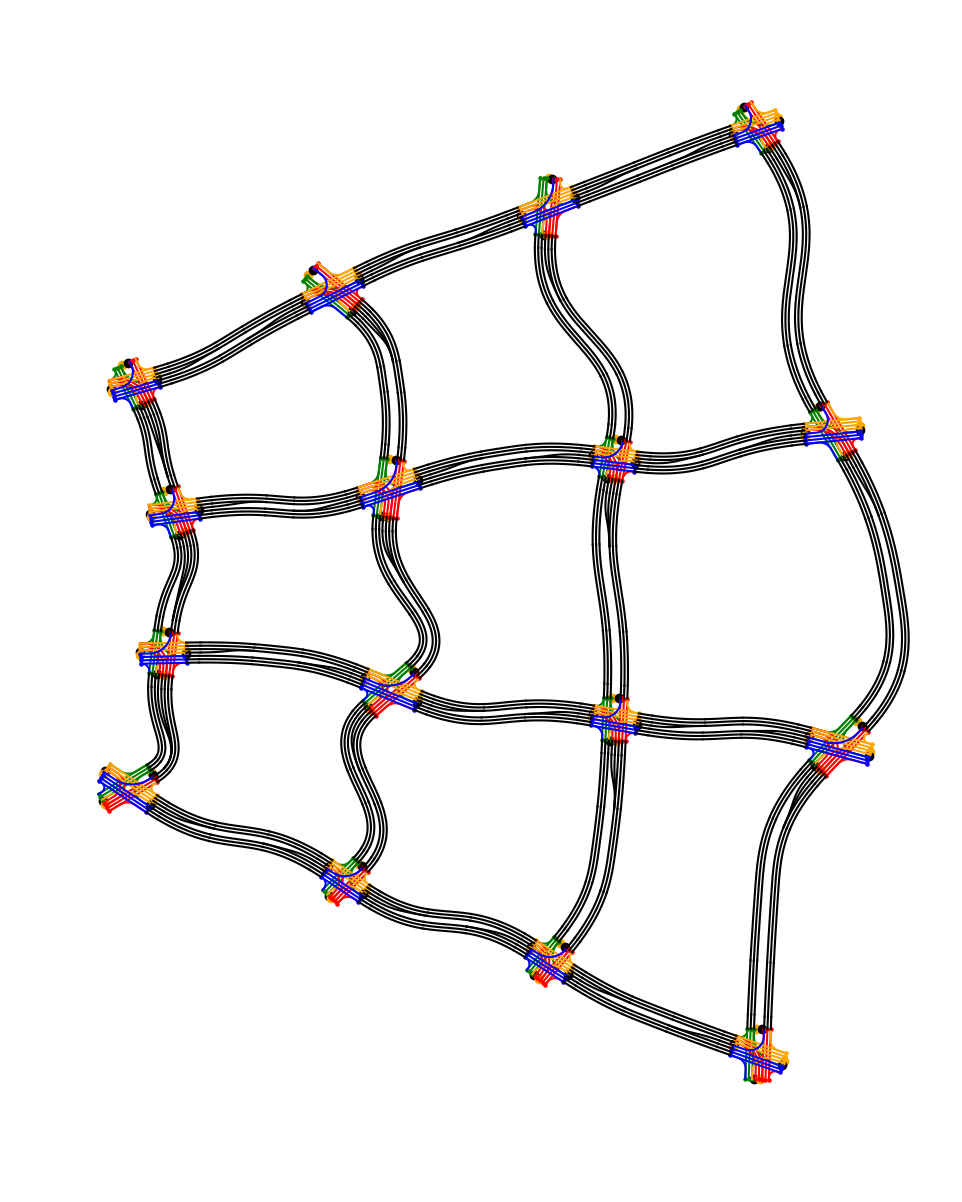

In [6]:
colors = Dict(
    :North => "red",
    :East => "blue",
    :South => "green",
    :West => "orange",
)

PyPlot.figure(figsize=[11.5,15])
for (_, intersection) in urbanMap.intersections
    for (direction, entrance) in intersection.entrances
        for (idx, lane_list) in entrance
            for laneID in lane_list
                PyPlot.plot(urbanMap.lanes[laneID].centerLine.x, urbanMap.lanes[laneID].centerLine.y, 
                    c=colors[direction]) #, linewidth=3+idx)
            end
        end
    end
    for (direction, refs) in intersection.refpoints
        PyPlot.scatter(refs[:in][1],refs[:in][2],c="orange")
        PyPlot.scatter(refs[:out][1],refs[:out][2],c="black")
    end
    for (direction, pts) in intersection.entrance_pts
        for (k, pt) in pts
            PyPlot.scatter(pt[1], pt[2], c=colors[direction], s=5)
        end
    end
    for (direction, pts) in intersection.exit_pts
        for (k, pt) in pts
            PyPlot.scatter(pt[1], pt[2], c=colors[direction], s=5)
        end
    end
end
for (_, road) in urbanMap.roads
#     PyPlot.plot(road.referenceLine.x, road.referenceLine.y, c="yellow")
    for lane_id in road.lanes
        lane = urbanMap.lanes[lane_id]
        PyPlot.plot(lane.centerLine.x, lane.centerLine.y, c="black")
    end
end
PyPlot.axis("off")
PyPlot.axis("equal");

# Generate Connecting Roadway Geometry (between intersections)

In [ ]:
# patch predecessors
for (lane_id, lane) in urbanMap.lanes
    for predecessor_id in lane.predecessors
        predecessor = urbanMap.lanes[predecessor_id]
        push!(predecessor.successors, lane_id)
    end
end

In [ ]:
PyPlot.figure(figsize=[11,11])
for (id, lane) in urbanMap.lanes
    PyPlot.plot(lane.centerLine.x, lane.centerLine.y, c="black")
end
PyPlot.axis("off")
PyPlot.axis("equal")

# Dubbins stuff

In [ ]:
# pt₁ = [rand();rand()]
# pt₂ = 10*[rand();rand()]
# θ = atan2((pt₂-pt₁)[1],(pt₂-pt₁)[2])
# θ₁ = θ + (rand() - 0.5) * 3*π/4
# θ₂ = θ + sign(θ - θ₁)*rand() * π/2

pt₁ = [1;-5]
pt₂ = [8;-3]
θ₁ = 2π/8
θ₂ = -π/4

pt₀ = pt₁ - 3*[cos(θ₁);sin(θ₁)]
pt₃ = pt₂ + 3*[cos(θ₂);sin(θ₂)]

x,y = Dubbins(pt₁,pt₂,θ₁,θ₂)
PyPlot.figure(figsize=[11,4])
PyPlot.subplot(1,2,1)
PyPlot.scatter([pt₁[1], pt₂[1]],[pt₁[2], pt₂[2]])
PyPlot.plot([pt₁[1], (Rot(θ₁)*[-1;0]+pt₁)[1]],[pt₁[2], (Rot(θ₁)*[-1;0]+pt₁)[2]])
PyPlot.plot([pt₂[1], (Rot(θ₂)*[1;0]+pt₂)[1]],[pt₂[2], (Rot(θ₂)*[1;0]+pt₂)[2]])
PyPlot.scatter(x,y)
PyPlot.axis("equal")

x,y = ExtendedDubbins(pt₀,pt₁,pt₂,pt₃;θ₁=θ₁,θ₂=θ₂)
PyPlot.subplot(1,2,2)
PyPlot.scatter([pt₁[1], pt₂[1]],[pt₁[2], pt₂[2]])
PyPlot.plot([pt₀[1], pt₁[1]],[pt₀[2], pt₁[2]])
PyPlot.plot([pt₂[1], pt₃[1]],[pt₂[2], pt₃[2]])
PyPlot.scatter(x,y)
PyPlot.axis("equal")